Ομάδα 94 - 2 ατόμων : Κριθαρούλα Αναστασία 03117073 - Κριθαρούλας Διονύσης 03117875

# Νευρωνικά Δίκτυα - Ροή Υ - 9ο Εξάμηνο - ΣΗΜΜΥ

### Μέρος 2.Kaggle Dataset - Βελτιστοποίηση SVM ταξινομητή.

In [ ]:
!pip install optuna
!pip install --upgrade scikit-learn 
!pip install --upgrade numpy 
!pip install --upgrade pandas 
!pip install --upgrade imbalanced-learn
!pip install --upgrade seaborn

Αρχικά δανιζόμαστε τους κώδικες από το part2 notebook προκειμένου να προχωρήσουμε στην εξέταση του ταξινομητή SVM.

#### Εισαγωγή του Dataframe αρχείου από το Kaggle.

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import os
# Complete path to storage location of the .zip file of data
zip_path = '/gdrive/MyDrive/kaggle/csgo-round-winner-classification.zip'
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly 
!unzip -q 'csgo-round-winner-classification.zip'
# View the unzipped contents in the virtual machine
os.listdir()

replace csgo_round_snapshots.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


['.config',
 'csgo-round-winner-classification.zip',
 'csgo_round_snapshots.csv',
 'sample_data']

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("csgo_round_snapshots.csv") #option header takes his default value
labels_df = df.iloc[:, [96]] 
features_df = df.iloc[:, :-1]

#### Αρχική προεπεξεργασία πριν την βελτισοποίηση (η ανάλυση της έχει γίνει στο notebook part2).

In [ ]:
mapping = {'T': 0, 'CT': 1}
labels_df = labels_df.replace({"round_winner": mapping}) 
np_labels = labels_df.values.flatten()

In [ ]:
print('Labels array dimension:', np_labels.shape)

Labels array dimension: (122410,)


In [ ]:
from sklearn.model_selection import train_test_split

#split dataset to train and test set
train_features_df, test_features_df, y_train, y_test = train_test_split(features_df, np_labels, test_size = 0.3, shuffle = True)

In [ ]:
def Dummies(train_df, test_df, column_list = ['map', 'bomb_planted']):
    train_df = pd.get_dummies(train_df, columns = column_list) #convert nominal attribute with m values to m binary attributes - only one of them is active at a time
    test_df = pd.get_dummies(test_df, columns = column_list)
    test_df = test_df.reindex(columns = train_df.columns, fill_value = 0)
    return train_df , test_df

In [ ]:
train_features_df , test_features_df = Dummies(train_features_df , test_features_df)

print('Number of attributes after Dummies:', train_features_df.shape[1])

Number of attributes after Dummies: 104


In [ ]:
X_train = train_features_df.apply(pd.to_numeric).values
X_test = test_features_df.apply(pd.to_numeric).values

#### Βελτιστοποίηση

##### SVM

Για την βελτιστοποίηση του ταξινομητή SVM θα χρησιμοποίησουμε τις ακόλουθες διαδικασίες:
* Προεπεξεργασία
* Ορισμού Pipelines
* εύρεσης βέλτιστων υπερμαραμέτρων με χρήση της βιβλιοθήκης Optuna

Ως προεπεξεργασία θα χρησιμοποιήσουμε τους ακόλουθους Μετασχηματιστές:
* Variance Threshold
* PCA (Ανάλυση σε κύριες συνιστώσες)
* Min Max Scaler (Κανονικοποίηση μέσω Διαίρεσης μεγίστου-ελαχίστου)
* Standard Scaler (Κανονικοποίηση μέσω Standard Score)

Το pipeline που θα χρησιμοποιήσουμε για την βελτιστοποίηση θα περιέχει μία σειρά από μετασχηματιστές που θα καταλήγει σε έναν ταξινομητή SVM. Έτσι ολόκληρο το pipeline μπορεί να θεωρηθεί ένας ταξινομητής πάνω στον οποίο μπορούμε να χρησιμοποιήσουμε τις μεθόδους που γνωρίζουμε.

Τόσο ο ταξινομητής SVM όσο και οι παραπάνω μετασχηματιστές έχουν έναν αριθμό από υπερπαραμέτρους τις οποίες χρειάζεται να βελτισοποιήσουμε. Οι υπερπαράμετροι αυτοί αναλύονται στην συνέχεια ξεχωριστά:

<u>Variance Threshold</u>

Ο μετασχηματιστής αυτός έχει μία υπερπαράμετρο, το λεγόμενο threshold ή όριο της διακύμανσης. Σύμφωνα με την τιμή του ορίου αυτού, χαρακτηριστικά που παρουσιάζουν διακύμανση μικρότερη της τικής αυτής απορίπτονται ολόκληρα από το Dataset μας. Η υπερπαράμετρος λοιπόν του συγκεκριμένου μετασχηματιστή θα πρέπει να βελτιστοποιηθεί σε συνδιασμό με τις υπόλοιπες υπερπαραμέτρους του pipeline που θα επιλεχθούν. 

Προκειμένου να έχουμε μία εικόνα για τις τιμές στις οποίες πρέπει να κυμανθεί η υπερπαράμετρος threshold που αναφέραμε προηγουμένως θα πρέπει να δούμε που κυμένεται η διασπορά των χαρακτηριστικών μας. Στο γράφημα που ακολουθεί αποτυπώνουμε την τιμή της διασποράς για κάθε χαρακτηριστικό του Dataset αφού πρώτα έχουμε εφαρμόσει σε αυτόν κανονικοποίηση μεγίστου-ελαχίστου (MinMaxScaler).Σύμφωνα με την κανονικοποίση αυτή οι τιμές όλων των χαρακτηριστικών κλιμακώνονται γραμμικά στο διάστημα [0,1].

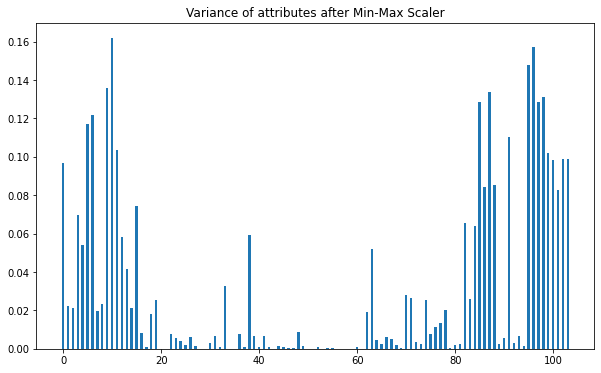

In [ ]:
from sklearn import preprocessing
from matplotlib import pyplot as plt

train_variance = preprocessing.MinMaxScaler().fit_transform(X_train).var(axis=0)

plt.figure(figsize = (10, 6))
plt.bar(range(0, train_variance.shape[0]), train_variance, width = 0.5)
plt.title("Variance of attributes after Min-Max Scaler")
plt.show()

Σύμφωνα με το παραπάνω γράφημα βλέπουμε ότι υπάρχουν αρκετά χαρακτηριστικά τα οποία η διακύμανση τους δεν ξεπερνάει το 0.02 (ίσως και το 0.01). Στην διαδικασία λοιπόν της βελτιστοποίησης των υπερπαραμέτρων θα φροντίσουμε το threeshold να κινείται στο διάστημα [0,0.02]. Προκειμένου βέβαια οι τιμές αυτές να ανταποκρίνονται έτσι όπως επιθυμούμε χρειάζεται πριν από την χρήση του Μετασχηματιστή VarianceThreshold να έχει χρησιμοποιηθεί ο μετασχηματιστής MinMaxScaler ώστε οι τιμές να είναι κανονικοποημένες όπως αναλύθηκε.

<u>PCA</u> (Ανάληση σε κύριες συνιστώσες)


Ο μετασχηματιστείς αυτός αναλύει το dataset μας στις κύριες συνιστώσες του μετασχηματίζοντας το ουσιαστικά σε ένα πρόβλημα μικρότερων διαστάσεων. Έτσι πλέον το dataset μας αποτελέιται από έναν μικρότερο αριθμό χαρακτηριστών. Ο αριθμός των κυρίων συνιστωσών στις οποίες θέλουμε να μετασχηματιστεί το Dataset μας αποτελεί την υπερπαράμετρο του συγκεκριμένου Μετασχηματιστή η οποία πρέπει επίσης να βελτισοποιηθεί σε συνδιασμό με τις υπόλοιπες παραμέτρους που θα επολεγούν. 

<u>SVM</u>

Ο ταξινομητής μας ο οποίος αποτελεί και το τελικό στάδιο του pipeline αποτελείται από έναν μεγάλο αριθμό υπερπαραμέτρων οι οποίες καθορίζουν τον τρόπο λειτουργίας του και την αρχιτεκτονική του. Κάποιες από τις υπερπαραμέτρους που χρησιμοποιήθηκαν είανι οι ακόλουθες:

<i><u>kernel (πυρήνας):</u> Η συγκεκριμένη υπερπαράμετρος καθορίζει τον τύπο του πυρήνα για τον ταξινομητή μας. Αυτός μπορεί να είναι: Linear , Gaussian radial basis function (RBF) , Sigmoid , Polynomial.

<i><u>Regularization Parameter (C):</u> Η συγκεκριμένη υπερπαράμετρος καθορίζει την σκληρότητα του περιθωρίου που εφαρμόζει ο SVM. Για μεγάλα C έχω σκληρό περιθώριο οπότε όλο και πιο δύσκολα επιτρέπεται σε σημεία να βρεθούν εντός του περιθωρίου. Για μικρά C έχω αντίστοιχα πιο μαλακό περιθώριο και άρα όλο και περισσότερα  δείγματα εισχωρούν μέσα στο περιθώριο.

<i><u>Kernel Coefficient (gamma):</u> Η συγκεκριμένη υπερπαράμετρος έχει νόημα μόνο σε
SVM που χρησιμοποιούν ως πηρύνα τους είτε rbf είτε polynomial είτε sigmoid. Η  παράμετρος αυτή μπορεί να πάρει ως τιμές είτε 'auto' είτε 'scaled' αλλά και οποινδήποτε πραγματικό αριθμό.

<i><u>Degree:</u> Η συγκεκριμένη υπερπαράμετρος έχει νόημα μόνο σε SVM που χρησιμοποοιούν τον πυρήνα polynomial και καθορίζει τον βαθμό του πολυωνύμου που θα χρησιμοποιηθεί.




In [ ]:
X_train_small, a, y_train_small, b = train_test_split(X_train, y_train, test_size = 0.9, shuffle = True)

In [ ]:
X_test_small, a, y_test_small, b = train_test_split(X_test, y_test, test_size = 0.9, shuffle = True)

#### Optuna

Η βιβλιοθήκη που επιλέχθηκε να χρησιμοποιηθεί για την βελτιστοποίηση των υπερπαραμέτρων είναι η optuna.  

Αρχικά επιλέξαμε να χρησιμοποιήσουμε αρκετές από τις υπερπαραμέτρους του ταξινομητή μας προκειμένου να έχουμε μια γενική εικόνα έτσι ώστε στην συνέχεια  να εστιάσουμε στις καλύτερες από αυτές. Μάλιστα κάποιοι υπερπαράμετροι όπως για παράδειγμα η τιμή C επιλέχθηκε να έχει διακριτές τιμές οι οποίες κυμαίνονται σε ένα αρκετά μεγάλο διάστημα. Οι τιμές αυτέ είναι οι 10,20,30,40,50,60,70,80,90,100,150,200. Με τον τρόπο αυτό θα μπορέσουμα να δούμε την συμπεριφορά του ταξινομητή μας σε μια ευρεία γκάμα τιμών ωστε έπειτα να εστιάσουμε στα διαστήματα όπου παρατηρείται η καλύτερη επίπδοση.
Οι μετασχηματιστές που αρχικά επιλέχθησαν είναι Min-Max Scaler και Variance Threshold (με το threshold να κυμαίνεται από 0 εως 0,15). Τέλος η αξιολόγηση του κάθε συνδιασμού επιλογών γίνεται με 5-hold cross validation όπου ως μετρική επιλέχθηκε για αρχή το accuracy. Έτσι έχουμε τα ακόλουθα αποτελέσματα: 

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold


def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['linear','rbf','poly','sigmoid'])
    svc_C = trial.suggest_categorical('svc_C',[10,20,30,40, 50, 60,70,80,90,100,120,150,180,200])

    if svc_kernel in ['rbf','poly','sigmoid']:

      svc_gamma = trial.suggest_categorical('svc__gamma',[0.00025, 0.0005, 0.001,0.005,0.01,0.0015,0.002,])
      if svc_kernel == 'poly':
        svc_degree = trial.suggest_int('svc_degree',1,10)
        svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C, degree = svc_degree)

      else:

        svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)

    else:

       svm = SVC(kernel = svc_kernel, C = svc_C)
      
      
    threshold = trial.suggest_float('threshold', 0.0, 0.15)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('svm', svm)])
   
    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2021-12-02 19:26:51,055] A new study created in memory with name: no-name-977d42f1-bbbf-4d55-8650-7ba21db68084
[I 2021-12-02 19:27:04,589] Trial 0 finished with value: 0.7483656791601868 and parameters: {'svc_kernel': 'rbf', 'svc_C': 50, 'svc__gamma': 0.0005, 'threshold': 0.01045553261204663}. Best is trial 0 with value: 0.7483656791601868.
[I 2021-12-02 19:27:16,255] Trial 1 finished with value: 0.7431134416545586 and parameters: {'svc_kernel': 'rbf', 'svc_C': 50, 'svc__gamma': 0.0015, 'threshold': 0.10160911583545452}. Best is trial 0 with value: 0.7483656791601868.
[I 2021-12-02 19:27:29,290] Trial 2 finished with value: 0.5087535021160854 and parameters: {'svc_kernel': 'poly', 'svc_C': 100, 'svc__gamma': 0.005, 'svc_degree': 6, 'threshold': 0.062260283721639484}. Best is trial 0 with value: 0.7483656791601868.
[I 2021-12-02 19:27:58,248] Trial 3 finished with value: 0.7464988375665257 and parameters: {'svc_kernel': 'linear', 'svc_C': 50, 'threshold': 0.0460715202917212}. Best is

Σύμφωνα με τα παραπάνω αποτέλεσματα μπορούμε να δούμε ότι η καλύτερη επίδοση όσο αναφορά το accuracy επιτυγχάνεται για τον ακόλουθο συνδιασμό υπερπαραμέτρων:

* kernel = rbf 
* C = 60
* gamma = 0.005
* threshold = 0.02

Το 5-fold cross validation accuracy που πετυχαίνουμε με τον παραπάνω συνδιασμό υπερπαραμέτρων είναι 0.7549 ή 75.49%

Γενικά μπορούμε να παρατηρήσουμε τα εξής αποτελέσματα:
* O SVM με kernel = rbf παρουσιάζει το καλύτερο accuracy το οποίο είναι περίπου 75.5%
* Ο SVM με kernel = sigmoid ή linear ακολουθούν με 75.4 accuracy.
* O SVM με kernel - poly παρουσιάζει πολύ κακή επίδοση με accuracy κοντά στο 53%.

Βέβαια εδώ χρειάζεται να παρατηρίσουμε ότι τα παραπάνω συμπεράσματα προέκυψαν από την επιλογή πολύ λίγων τιμών για τις παραμέτρους C , gamma , degree του SVM. Στην συνέχεια αναλύεται ο ταξινομητής SVM για κάθε kernel ξεχωριστά όπου οι παράμετροι του ταξινομιτή αξιολογούνται για πολύ μεγαλύτερο εύρος τιμών. 

Στην συνέχεια ακολουθούμε την ίδια διαδικασία επιλέγοντας αυτήν την φορά την f1 ως μέτρο της επίδοσης:

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold


def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['linear','rbf','poly','sigmoid'])
    svc_C = trial.suggest_categorical('svc_C',[10,20,30,40, 50, 60,70,80,90,100,120,150,180,200])

    if svc_kernel in ['rbf','poly','sigmoid']:

      svc_gamma = trial.suggest_categorical('svc__gamma',[0.00025, 0.0005, 0.001,0.005,0.01,0.0015,0.002,])
      if svc_kernel == 'poly':
        svc_degree = trial.suggest_int('svc_degree',1,10)
        svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C, degree = svc_degree)

      else:

        svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)

    else:

       svm = SVC(kernel = svc_kernel, C = svc_C)
      
      
    threshold = trial.suggest_float('threshold', 0.0, 0.15)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('svm', svm)])
   
    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'f1'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)

[I 2021-12-03 14:25:32,458] A new study created in memory with name: no-name-962a718c-780f-42ba-a652-ae79079b7410
[I 2021-12-03 14:25:44,048] Trial 0 finished with value: 0.0 and parameters: {'svc_kernel': 'poly', 'svc_C': 30, 'svc__gamma': 0.002, 'svc_degree': 10, 'threshold': 0.10314442403421005}. Best is trial 0 with value: 0.0.
[I 2021-12-03 14:25:58,443] Trial 1 finished with value: 0.7498140987964443 and parameters: {'svc_kernel': 'linear', 'svc_C': 10, 'threshold': 0.07553873390301985}. Best is trial 1 with value: 0.7498140987964443.
[I 2021-12-03 14:26:10,348] Trial 2 finished with value: 0.6077463617630864 and parameters: {'svc_kernel': 'rbf', 'svc_C': 30, 'svc__gamma': 0.00025, 'threshold': 0.13842332161962786}. Best is trial 1 with value: 0.7498140987964443.
[I 2021-12-03 14:26:29,352] Trial 3 finished with value: 0.0 and parameters: {'svc_kernel': 'poly', 'svc_C': 10, 'svc__gamma': 0.002, 'svc_degree': 8, 'threshold': 0.016977001288778226}. Best is trial 1 with value: 0.749

Σύμφωνα με τα παραπάνω αποτέλεσματα μπορούμε να δούμε ότι η καλύτερη επίδοση όσο αναφορά το f1 score επιτυγχάνεται για τον ακόλουθο συνδιασμό υπερπαραμέτρων:

* kernel = sigmoid
* C = 80
* gamma = 0.00025
* threshold = 0.04239392096955556

Το 5-fold cross validation f1 score που πετυχαίνουμε με τον παραπάνω συνδιασμό υπερπαραμέτρων είναι 0.7585 ή 75.85%

Γενικά μπορούμε να παρατηρήσουμε τα εξής αποτελέσματα:
* O SVM με kernel = sigmoid παρουσιάζει το καλύτερο f1 score το οποίο είναι περίπου 75.85%
* Ο SVM με kernel = rbf ακολουθεί με 75.7% f1 score.
* O SVM με kernel - poly ακολουθεί με accuracy κοντά στο 75.1%.
* Ο SVM με kernel = linear ακολουθεί με 75% f1 score.


Στην συνέχεια επικεντρωνόμαστε σε κάθε πυρήνα ξεχωριστά όπου δοκιμάζουμε διαφορετικές τιμές υπερπαραμέτρων αλλά και διαφορετικές αρχιτεκτονικές (επιλέγοντας δηλαδή διαφορετικούς μετασχηματιστές) τόσο για το accuracy όσο και για το f1 score.

#### RBF

Αρχικά αξιολογούμε τον SVM με kernel = rbf για ένα εύρος παραμέτρων προσθέτωντας αρχικά ως μετασχηματιστή μόνο έναν MinMax Scaler  

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold


def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['rbf'])
    svc_C = trial.suggest_float('svc_C',1.0,100.0)


    svc_gamma = trial.suggest_float('svc__gamma',0,0.2)
 

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)


    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()) , ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)

[I 2021-12-02 23:23:40,398] A new study created in memory with name: no-name-a8aea4bc-5f83-4a0a-b71c-2a85e565897d
[I 2021-12-02 23:24:01,274] Trial 0 finished with value: 0.7528013182193141 and parameters: {'svc_kernel': 'rbf', 'svc_C': 55.1813417822861, 'svc__gamma': 0.026670581518014092}. Best is trial 0 with value: 0.7528013182193141.
[I 2021-12-02 23:24:19,718] Trial 1 finished with value: 0.754901259569726 and parameters: {'svc_kernel': 'rbf', 'svc_C': 2.0304335307585504, 'svc__gamma': 0.1271070086880602}. Best is trial 1 with value: 0.754901259569726.
[I 2021-12-02 23:24:42,954] Trial 2 finished with value: 0.7452144728927871 and parameters: {'svc_kernel': 'rbf', 'svc_C': 26.87250481042073, 'svc__gamma': 0.12270633873122153}. Best is trial 1 with value: 0.754901259569726.
[I 2021-12-02 23:25:01,032] Trial 3 finished with value: 0.7498832798266533 and parameters: {'svc_kernel': 'rbf', 'svc_C': 39.687366138396506, 'svc__gamma': 0.0023935992964011945}. Best is trial 1 with value: 0.

Παρατηρούμε ότι παρότι χρησιμοποιήσαμε μόνο έναν Μετασχηματιστή (MinMaxScaler) η καλύτερη απόδοση για kernel rbf είναι 75.6% (accuracy). Η τιμή αυτή είναι καλύτερη από αυτήν που βρήκαμε στο προηγούμενο παράδειγμα. Κάτι τέτοιο ίσως οφείλεται στο γεγονός πως έχουμε χρησιμοποιήσει ένα πολύ μεγαλύτερο εύρος τιμών για τις παραμέτρους του ταξινομητή μας.

Επιπλέν παρατηρούμε ότι τόσο η υπρπερπαράμετρος gamma όσο και η υπερπαράμετρος C δεν έχουν κάποια ευδιάκριτη συμπεριφορά που επηρεάζει την απόδοση του ταξινομητή όσο αναφορά το accuracy του. Θα μπορούσαμε να πούμε ότι για τιμές C μεταξύ (0,100) και τιμές gamma μεταξύ (0,0.1) έχουμε περίπου παρόμοια αποτελέσματα.

Στην συνέχεια επιλέγουμε αντί για MinMaxScaler StandardScaler και βλέπουμε τα αποτελέσματα του:

In [ ]:

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold


def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['rbf'])
    svc_C = trial.suggest_float('svc_C',1.0,100.0)


    svc_gamma = trial.suggest_float('svc__gamma',0,0.2)
 

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)


    clf = Pipeline(steps = [('standard_scaler', preprocessing.StandardScaler()) , ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 30)

[I 2021-12-02 23:50:02,020] A new study created in memory with name: no-name-537b6f22-f718-41fa-8cad-4caaa42721b8
[I 2021-12-02 23:50:31,644] Trial 0 finished with value: 0.716733115764478 and parameters: {'svc_kernel': 'rbf', 'svc_C': 11.670154450054255, 'svc__gamma': 0.14371234296087884}. Best is trial 0 with value: 0.716733115764478.
[I 2021-12-02 23:51:00,839] Trial 1 finished with value: 0.7340074970658177 and parameters: {'svc_kernel': 'rbf', 'svc_C': 16.774663770654485, 'svc__gamma': 0.10169650816128724}. Best is trial 1 with value: 0.7340074970658177.
[I 2021-12-02 23:51:30,961] Trial 2 finished with value: 0.740310113954583 and parameters: {'svc_kernel': 'rbf', 'svc_C': 79.66506315018272, 'svc__gamma': 0.07520955720139591}. Best is trial 2 with value: 0.740310113954583.
[I 2021-12-02 23:52:00,454] Trial 3 finished with value: 0.722568375133937 and parameters: {'svc_kernel': 'rbf', 'svc_C': 27.958944323293153, 'svc__gamma': 0.1344572862337069}. Best is trial 2 with value: 0.740

Παραητηρούμε ότι στην περίπτωση του StandardScaler έχουμε χειρότερα αποτελέσματα με το μέγιστο accuracy να είναι 75.45% έχοντας το ίδιο εύρος για τις παραμέτρους C και gamma του ταξινομητή μας.
Στην συνέχεια λοιπόν επανερχόμαστε στον MinMaxScaler προσθέτωντας αμέσως μετά και πρίν τον ταξινομητή μας ένα VarianceThreshold.

<u>Σημείωση</u>: Όπως αναφέραμε και παραπάνω το Variance Threshold για να λειτουργήσει σωστά χρειάζεται προηγουμένως έναν MinMax Scaler.


Στην συνέχεια προσθέτουμε και VarianceThreshold αμέσως μετά τον MinMax Scaler. 
Έτσι λοιπόν έχουμε τα εξής αποτελέσματα:

In [ ]:
def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['rbf'])
    svc_C = trial.suggest_int('svc_C',1,100)


    svc_gamma = trial.suggest_categorical('svc_gamma',['scale','auto'])
 

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)


      
      
    threshold = trial.suggest_float('threshold', 0, 0.1)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2021-12-02 21:26:38,458] A new study created in memory with name: no-name-3b410b42-188c-42d8-9bee-b8b5d36b68c3
[I 2021-12-02 21:26:53,677] Trial 0 finished with value: 0.7463831051040127 and parameters: {'svc_kernel': 'rbf', 'svc_C': 16, 'svc__gamma': 'scale', 'threshold': 0.02424530917696799}. Best is trial 0 with value: 0.7463831051040127.
[I 2021-12-02 21:27:07,553] Trial 1 finished with value: 0.7535020479673252 and parameters: {'svc_kernel': 'rbf', 'svc_C': 10, 'svc__gamma': 'auto', 'threshold': 0.05177934873640562}. Best is trial 1 with value: 0.7535020479673252.
[I 2021-12-02 21:27:26,580] Trial 2 finished with value: 0.7405462790208175 and parameters: {'svc_kernel': 'rbf', 'svc_C': 34, 'svc__gamma': 'scale', 'threshold': 0.03900370730550822}. Best is trial 1 with value: 0.7535020479673252.
[I 2021-12-02 21:27:53,584] Trial 3 finished with value: 0.7279415901871951 and parameters: {'svc_kernel': 'rbf', 'svc_C': 80, 'svc__gamma': 'scale', 'threshold': 0.021554191250644585}. Be

Παρατηρούμε ότι η χρήση του VarianceThreshold αύξησε την επίδοση του ταξινομητή μας. Το μέγιστο accuracy είναι 75.87% και παρατηρείται για threshold 0.008. Στην περίπτωση αυτή βέβαια μεταβάλαμε και το gamma το οποίο πλέον παίρνει δύο τιμές , τις auto και scale.

Στην συνέχεια προσθέτουμε τον μετασχηματιστή PCA στο pipeline μας δοκιμόζαντας και την περίπτωση που η υπερπαράμετρος gamma παίρνει συνεχείς πραγματικές τιμές αλλά και την περίπτωση που παίρει τιμές auto η scale.

Αρχικά βάζουμε το gamma να παίρνει τιμές scaled ,auto

In [ ]:
from sklearn.decomposition import PCA

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['rbf'])

    svc_C = trial.suggest_int('svc_C',1,100)

    svc_gamma = trial.suggest_categorical('svc_gamma',['auto', 'scale'])
    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)
            
    threshold = trial.suggest_float('threshold', 0, 0.1)

    p = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold))])
    upper_bound = p.fit_transform(X_train_small).shape[1]

    if (upper_bound<=80):

      n_components = trial.suggest_int('n_components', min(upper_bound, 5), upper_bound)

    else:

      n_components = trial.suggest_int('n_components', min(upper_bound, 5) , 80)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('pca', PCA(n_components=n_components)),('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 30)

[I 2021-12-03 13:34:53,782] A new study created in memory with name: no-name-d8bc1c26-05d6-4afc-8c4c-692ef98bc246
[I 2021-12-03 13:35:07,143] Trial 0 finished with value: 0.7356432143243955 and parameters: {'svc_kernel': 'rbf', 'svc_C': 10, 'svc_gamma': 'auto', 'threshold': 0.016466364352146514, 'n_components': 9}. Best is trial 0 with value: 0.7356432143243955.
[I 2021-12-03 13:35:23,136] Trial 1 finished with value: 0.7464969983808354 and parameters: {'svc_kernel': 'rbf', 'svc_C': 37, 'svc_gamma': 'auto', 'threshold': 0.036964721389599865, 'n_components': 19}. Best is trial 1 with value: 0.7464969983808354.
[I 2021-12-03 13:35:59,024] Trial 2 finished with value: 0.715684303095077 and parameters: {'svc_kernel': 'rbf', 'svc_C': 84, 'svc_gamma': 'scale', 'threshold': 0.05813176533161229, 'n_components': 29}. Best is trial 1 with value: 0.7464969983808354.
[I 2021-12-03 13:36:18,328] Trial 3 finished with value: 0.7484811391507458 and parameters: {'svc_kernel': 'rbf', 'svc_C': 92, 'svc_

Έπειτα ορίζουμε το gamma να παίρνει συνεχείς πραγματικές τιμές στο διάστημα (0.0001 , 0.3)

In [ ]:
from sklearn.decomposition import PCA

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['rbf'])

    svc_C = trial.suggest_int('svc_C',1,100)

    svc_gamma = trial.suggest_float('svc_gamma',0.0001,0.3)
    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)
            
    threshold = trial.suggest_float('threshold', 0, 0.1)

    p = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold))])
    upper_bound = p.fit_transform(X_train_small).shape[1]

    if (upper_bound<=80):

      n_components = trial.suggest_int('n_components', min(upper_bound, 5), upper_bound)

    else:

      n_components = trial.suggest_int('n_components', min(upper_bound, 5) , 80)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('pca', PCA(n_components=n_components)),('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2021-12-03 00:35:18,499] A new study created in memory with name: no-name-97709b0c-e995-4822-a9aa-cca6cafa6225
[I 2021-12-03 00:35:33,682] Trial 0 finished with value: 0.7373949365174406 and parameters: {'svc_kernel': 'rbf', 'svc_C': 18, 'svc_gamma': 0.25227444916716124, 'threshold': 0.06044114462328856, 'n_components': 21}. Best is trial 0 with value: 0.7373949365174406.
[I 2021-12-03 00:35:55,436] Trial 1 finished with value: 0.7365785424249051 and parameters: {'svc_kernel': 'rbf', 'svc_C': 95, 'svc_gamma': 0.24203089299112562, 'threshold': 0.03478987955336601, 'n_components': 15}. Best is trial 0 with value: 0.7373949365174406.
[I 2021-12-03 00:36:23,060] Trial 2 finished with value: 0.7309741349185751 and parameters: {'svc_kernel': 'rbf', 'svc_C': 81, 'svc_gamma': 0.2441411207528551, 'threshold': 0.037629351284946405, 'n_components': 29}. Best is trial 0 with value: 0.7373949365174406.
[I 2021-12-03 00:36:38,033] Trial 3 finished with value: 0.7546685004029179 and parameters: {'

Παρατηρούμε ότι δεν έχουμε καποια αισθητή βελτίωση με την προσθήκη του Μετασχηματιστή PCA σε καμοία από τις δύο περιπώσεις. Μάλιστα το μέγιστο accuracy που παίρνουμε (75.85%) είναι μικρότερο από αυτό που πετύχαμε χρησιμοποιώντας μόνο MinMax Scaler και στην συνέχεια Threshold. Έχοντας ως κανονά πως μεταξύ δύο αρχιτεκτονικών που πετυχαίνουν παρόμοια επίδοση η σωστή επιλογή είναι η πιο απλή προτιμάμε να αφήσουμε εκτός το PCA από την τελίκή αρχιτεκτινική μας.

Τελικά με βάση τις προηγούμενες επιλογές αρχιτεκτονικής θα δούμε πλέον την επίδραση των υπερπαραμέτρων του ταξινομητή μας (SVM) όπου και πάλι η τιμή της υπερπαραμέτρου gamma στην μία περίπτωση παίρνει πραγματικές τιμές και στην άλλη auto και scale. Έτσι έχουμε τα εξής αποτελέσματα : 

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['rbf'])
    svc_C = trial.suggest_float('svc_C',1,200)

    svc_gamma = trial.suggest_categorical('svc_gamma',['auto','scale'])

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)

    threshold = trial.suggest_float('threshold', 0, 0.1)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)

[I 2021-12-03 13:46:59,892] A new study created in memory with name: no-name-bb1e13a8-b261-4b43-8274-1ae4feb55076
[I 2021-12-03 13:47:15,578] Trial 0 finished with value: 0.7449798064223001 and parameters: {'svc_kernel': 'rbf', 'svc_C': 9.307537393510383, 'svc_gamma': 'scale', 'threshold': 0.04426264408774086}. Best is trial 0 with value: 0.7449798064223001.
[I 2021-12-03 13:47:57,051] Trial 1 finished with value: 0.7247878635542195 and parameters: {'svc_kernel': 'rbf', 'svc_C': 193.7078353800449, 'svc_gamma': 'scale', 'threshold': 0.07219518773186633}. Best is trial 0 with value: 0.7449798064223001.
[I 2021-12-03 13:48:21,160] Trial 2 finished with value: 0.7440467262154122 and parameters: {'svc_kernel': 'rbf', 'svc_C': 187.35571725345062, 'svc_gamma': 'auto', 'threshold': 0.0548254897540548}. Best is trial 0 with value: 0.7449798064223001.
[I 2021-12-03 13:48:52,828] Trial 3 finished with value: 0.7324914631130873 and parameters: {'svc_kernel': 'rbf', 'svc_C': 136.43705512455605, 'sv

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['rbf'])
    svc_C = trial.suggest_float('svc_C',1,200)

    svc_gamma = trial.suggest_float('svc_gamma',0.0,0.5) 

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)

    threshold = trial.suggest_float('threshold', 0, 0.1)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2021-12-03 13:02:48,337] A new study created in memory with name: no-name-e0faa163-c5c4-4961-9e5c-ab2f6370c172
[I 2021-12-03 13:03:17,211] Trial 0 finished with value: 0.7324897601633742 and parameters: {'svc_kernel': 'rbf', 'svc_C': 86.41097127105094, 'svc_gamma': 0.18773355500308603, 'threshold': 0.05911220578569224}. Best is trial 0 with value: 0.7324897601633742.
[I 2021-12-03 13:03:46,978] Trial 1 finished with value: 0.7260710702221532 and parameters: {'svc_kernel': 'rbf', 'svc_C': 65.02902906203514, 'svc_gamma': 0.2668808740902366, 'threshold': 0.03425016340751321}. Best is trial 0 with value: 0.7324897601633742.
[I 2021-12-03 13:04:07,905] Trial 2 finished with value: 0.7340074289478291 and parameters: {'svc_kernel': 'rbf', 'svc_C': 30.350983064752544, 'svc_gamma': 0.186567656553985, 'threshold': 0.027286622132913132}. Best is trial 2 with value: 0.7340074289478291.
[I 2021-12-03 13:04:34,801] Trial 3 finished with value: 0.718601864661818 and parameters: {'svc_kernel': 'rbf

Παρατηρούμε ότι η μέγιστη επίδοση που πετυχαίνουμε για kernel = rbf είναι 75.44% accuracy.
Την επίδοση αυτή την πετυχαίνουμε για τις ακόλουθες τιμές υπερπαραμέτρων:

* kernel = rbf
* C =  1.384105550450471 
* gamma = 'auto' 
* threshold =0.009180125108883955



In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['rbf'])
    svc_C = trial.suggest_float('svc_C',1,200)

    svc_gamma = trial.suggest_float('svc_gamma',0.0,0.5) 

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)

    threshold = trial.suggest_float('threshold', 0, 0.1)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'f1' , n_jobs = -1))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2021-12-03 16:15:45,638] A new study created in memory with name: no-name-439f659c-e5eb-41d7-a0bf-bb5946f23562
[I 2021-12-03 16:15:55,279] Trial 0 finished with value: 0.6968786707056358 and parameters: {'svc_kernel': 'rbf', 'svc_C': 153.55237166039157, 'svc_gamma': 0.18537706627058215, 'threshold': 0.027225552062338357}. Best is trial 0 with value: 0.6968786707056358.
[I 2021-12-03 16:16:01,372] Trial 1 finished with value: 0.7113366067929625 and parameters: {'svc_kernel': 'rbf', 'svc_C': 104.50657418446573, 'svc_gamma': 0.31311826542887655, 'threshold': 0.08986034242780984}. Best is trial 1 with value: 0.7113366067929625.
[I 2021-12-03 16:16:05,288] Trial 2 finished with value: 0.7190124622520854 and parameters: {'svc_kernel': 'rbf', 'svc_C': 21.957544056555754, 'svc_gamma': 0.4456108887051065, 'threshold': 0.09723090129574083}. Best is trial 2 with value: 0.7190124622520854.
[I 2021-12-03 16:16:09,982] Trial 3 finished with value: 0.7242710746791168 and parameters: {'svc_kernel':

Παρατηρούμε ότι η μέγιστη επίδοση που πετυχαίνουμε για kernel = rbf είναι 74.63% f1-score.
Την επίδοση αυτή την πετυχαίνουμε για τις ακόλουθες τιμές υπερπαραμέτρων:

* kernel = rbf
* C =  49.0166465572452
* gamma = 0.06071249745874641
* threshold = 0.0372111593761334


#### Linear

Όπως και στην περίπτωση του rbf αρχικά προσθέτουμε ως μετασχηματιστή μόνο έναν MinMax Scaler. Έτσι έχουμε:

In [ ]:
def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['linear'])
    svc_C = trial.suggest_float('svc_C',1,100)

    svm = SVC(kernel = svc_kernel, C = svc_C)
      
    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()),('svm', svm)])

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 30)

[I 2021-12-03 01:45:27,331] A new study created in memory with name: no-name-d2122c37-acf3-4d3d-bb45-ab1bdc531a13
[I 2021-12-03 01:46:15,516] Trial 0 finished with value: 0.7499997615870402 and parameters: {'svc_kernel': 'linear', 'svc_C': 53.10307946808297}. Best is trial 0 with value: 0.7499997615870402.
[I 2021-12-03 01:47:00,256] Trial 1 finished with value: 0.7498829392367107 and parameters: {'svc_kernel': 'linear', 'svc_C': 45.33485949726951}. Best is trial 0 with value: 0.7499997615870402.
[I 2021-12-03 01:48:13,819] Trial 2 finished with value: 0.7508167006234839 and parameters: {'svc_kernel': 'linear', 'svc_C': 99.13786593506595}. Best is trial 2 with value: 0.7508167006234839.
[I 2021-12-03 01:48:40,317] Trial 3 finished with value: 0.7494162628972896 and parameters: {'svc_kernel': 'linear', 'svc_C': 16.099475667131216}. Best is trial 2 with value: 0.7508167006234839.
[I 2021-12-03 01:49:09,356] Trial 4 finished with value: 0.7497665937123009 and parameters: {'svc_kernel': 'l

Παρατηρούμε ότι με χρήση μόνο του MinMax Scaler πριν τον ταξινομητή μας επιτυγχάνουμε μέγιστο accuracy 75% δείχνοντας πως και στην περίπτωση του linear ο MinMax Scaler ανταποκρίνεται αρκετά καλά. Επιπλέον για υπερπαράμετρο C από 0 εώς 100 βλέπουμε ότι ο ταξινομητής μας δεν έχει κάποια αισθητή διαφορά ως προς το accuracy του

Στην συνέχεια επιλέγουμε αντί για MinMaxScaler StandarScaler και βλέπουμε τα αποτελέσματα του:

In [ ]:
X_train_small, a, y_train_small, b = train_test_split(X_train, y_train, test_size = 0.95, shuffle = True)
X_test_small, a, y_test_small, b = train_test_split(X_test, y_test, test_size = 0.95, shuffle = True)

In [ ]:
def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['linear'])
    svc_C = trial.suggest_float('svc_C',1,100)

    svm = SVC(kernel = svc_kernel, C = svc_C)
      
    clf = Pipeline(steps = [('StandardScalerard_scaler', preprocessing.StandardScaler()),('svm', svm)])

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy' , n_jobs =-1))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 10)

[I 2021-12-03 18:13:03,338] A new study created in memory with name: no-name-a1cf570b-6474-40fe-9f28-9ff0647f2b98
[I 2021-12-03 18:13:51,547] Trial 0 finished with value: 0.7434653049651578 and parameters: {'svc_kernel': 'linear', 'svc_C': 8.09333453177699}. Best is trial 0 with value: 0.7434653049651578.
[I 2021-12-03 18:16:01,745] Trial 1 finished with value: 0.7448655383373864 and parameters: {'svc_kernel': 'linear', 'svc_C': 22.811854012125004}. Best is trial 1 with value: 0.7448655383373864.
[I 2021-12-03 18:22:08,982] Trial 2 finished with value: 0.7441654216512721 and parameters: {'svc_kernel': 'linear', 'svc_C': 64.431213384202}. Best is trial 1 with value: 0.7448655383373864.
[I 2021-12-03 18:27:29,916] Trial 3 finished with value: 0.7441654216512721 and parameters: {'svc_kernel': 'linear', 'svc_C': 57.77719078382158}. Best is trial 1 with value: 0.7448655383373864.
[I 2021-12-03 18:34:28,410] Trial 4 finished with value: 0.7441651490201638 and parameters: {'svc_kernel': 'line

Παραητηρούμε ότι στην περίπτωση του StandardScaler έχουμε ελαφρώς χειρότερα αποτελέσματα με το μέγιστο accuracy να είναι 74.48%.
Στην συνέχεια λοιπόν επανερχόμαστε στον MinMaxScaler προσθέτωντας αμέσως μετά και πρίν τον ταξινομητή μας ένα VarianceThreshold. 
Έτσι λοιπόν έχουμε τα εξής αποτελέσματα:

In [ ]:
def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['linear'])
    svc_C = trial.suggest_int('svc_C',1,100)


 
    svm = SVC(kernel = svc_kernel, C = svc_C)


      
      
    threshold = trial.suggest_float('threshold', 0, 0.1)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy' , n_jobs = -1))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)

[I 2021-12-03 14:47:23,048] A new study created in memory with name: no-name-e66e41f6-0c18-4bb5-82dd-9e68ec81ba4e
[I 2021-12-03 14:47:31,169] Trial 0 finished with value: 0.7352967316982737 and parameters: {'svc_kernel': 'linear', 'svc_C': 87, 'threshold': 0.08574804203080777}. Best is trial 0 with value: 0.7352967316982737.
[I 2021-12-03 14:47:50,966] Trial 1 finished with value: 0.7373992628054831 and parameters: {'svc_kernel': 'linear', 'svc_C': 100, 'threshold': 0.005199607763843351}. Best is trial 1 with value: 0.7373992628054831.
[I 2021-12-03 14:48:00,203] Trial 2 finished with value: 0.738566941842332 and parameters: {'svc_kernel': 'linear', 'svc_C': 43, 'threshold': 0.010621561873065056}. Best is trial 2 with value: 0.738566941842332.
[I 2021-12-03 14:48:06,858] Trial 3 finished with value: 0.7376307266164298 and parameters: {'svc_kernel': 'linear', 'svc_C': 70, 'threshold': 0.07758004532527704}. Best is trial 2 with value: 0.738566941842332.
[I 2021-12-03 14:48:10,465] Trial 

Έχοντας ως Μετασχηματιστές τον MinMax Scaler και τον Variance Threshold παίρνουμε μέγιστο accuracy 74.65% για τιμές υπερπαραμέτρων:

* kernel = linear
* C =  17 

Στην συνέχεια προσθέτουμε τον μετασχηματιστή PCA στο pipeline μας

In [ ]:
from sklearn.decomposition import PCA

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['linear'])

    svc_C = trial.suggest_float('svc_C',1,100)

    
    svm = SVC(kernel = svc_kernel, C = svc_C)
            
    threshold = trial.suggest_float('threshold', 0, 0.1)

    p = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold))])
    upper_bound = p.fit_transform(X_train_small).shape[1]

    
    n_components = trial.suggest_int('n_components', min(upper_bound, 5), upper_bound)
    #print(upper_bound,p.fit_transform(X_train_small).shape[0],n_components)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('pca', PCA(n_components=n_components)),('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 30)

[I 2021-12-03 14:59:40,359] A new study created in memory with name: no-name-e4cc87f4-0644-4958-8382-c8904b502873
[I 2021-12-03 14:59:49,312] Trial 0 finished with value: 0.7124278890718546 and parameters: {'svc_kernel': 'linear', 'svc_C': 99.11213948851095, 'threshold': 0.018325073265480652, 'n_components': 8}. Best is trial 0 with value: 0.7124278890718546.
[I 2021-12-03 14:59:56,099] Trial 1 finished with value: 0.7063536679789311 and parameters: {'svc_kernel': 'linear', 'svc_C': 64.76054816645629, 'threshold': 0.06831414079865436, 'n_components': 6}. Best is trial 0 with value: 0.7124278890718546.
[I 2021-12-03 15:00:04,059] Trial 2 finished with value: 0.7324951744293832 and parameters: {'svc_kernel': 'linear', 'svc_C': 70.46146845219948, 'threshold': 0.056611687624689655, 'n_components': 16}. Best is trial 2 with value: 0.7324951744293832.
[I 2021-12-03 15:00:09,443] Trial 3 finished with value: 0.7072874295248585 and parameters: {'svc_kernel': 'linear', 'svc_C': 30.9884305036585

Παρατηρούμε ότι όπως και στην περίπτωση του rbf το PCA δεν βελτιώνει την απόδοση του ταξινομητή μας καθώς το μέγιστο accuracy που πετυχαίνουμε είναι 74.46%

Τελικά με βάση τις προηγούμενες επιλογές αρχιτεκτονικής θα δούμε πλέον την επίδραση των υπερπαραμέτρων του ταξινομητή μας (SVM). Έτσι έχουμε τα εξής αποτελέσματα:

In [ ]:
def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['linear'])

    svc_C = trial.suggest_float('svc_C',1,100)

    svm = SVC(kernel = svc_kernel, C = svc_C)
            
    threshold = trial.suggest_float('threshold', 0, 0.1)


    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy' , n_jobs = -1))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2021-12-03 15:03:07,421] A new study created in memory with name: no-name-8278ac8b-4ece-4925-9dee-9caf8f899b9d
[I 2021-12-03 15:03:14,811] Trial 0 finished with value: 0.7432332958919945 and parameters: {'svc_kernel': 'linear', 'svc_C': 32.78826148707154, 'threshold': 0.03863581061045961}. Best is trial 0 with value: 0.7432332958919945.
[I 2021-12-03 15:03:24,584] Trial 1 finished with value: 0.7404320112542122 and parameters: {'svc_kernel': 'linear', 'svc_C': 81.29450302472735, 'threshold': 0.05427408989687922}. Best is trial 0 with value: 0.7432332958919945.
[I 2021-12-03 15:03:32,744] Trial 2 finished with value: 0.7411321279403265 and parameters: {'svc_kernel': 'linear', 'svc_C': 61.261971174727975, 'threshold': 0.056909651706224224}. Best is trial 0 with value: 0.7432332958919945.
[I 2021-12-03 15:03:37,576] Trial 3 finished with value: 0.7322609843073534 and parameters: {'svc_kernel': 'linear', 'svc_C': 51.07448238554283, 'threshold': 0.09189307770998928}. Best is trial 0 with

Παρατηρούμε ότι η μέγιστη επίδοση που πετυχαίνουμε για kernel = linear είναι 74.69% accuracy.
Την επίδοση αυτή την πετυχαίνουμε για τις ακόλουθες τιμές υπερπαραμέτρων:

* kernel = linear
* C =  53.48212868147047
* threshold = 0.048139859240600574

In [ ]:
def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['linear'])

    svc_C = trial.suggest_float('svc_C',1,100)

    svm = SVC(kernel = svc_kernel, C = svc_C)
            
    threshold = trial.suggest_float('threshold', 0, 0.1)


    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'f1' , n_jobs = -1))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2021-12-03 16:26:26,761] A new study created in memory with name: no-name-448d6ee0-1d6e-49ef-8328-94f91f62edf5
[I 2021-12-03 16:26:30,570] Trial 0 finished with value: 0.7419785829399346 and parameters: {'svc_kernel': 'linear', 'svc_C': 7.9546785119242305, 'threshold': 0.05278636436073504}. Best is trial 0 with value: 0.7419785829399346.
[I 2021-12-03 16:26:36,273] Trial 1 finished with value: 0.7332617460127475 and parameters: {'svc_kernel': 'linear', 'svc_C': 69.05482130838294, 'threshold': 0.0910131082350272}. Best is trial 0 with value: 0.7419785829399346.
[I 2021-12-03 16:26:45,878] Trial 2 finished with value: 0.7408310194460699 and parameters: {'svc_kernel': 'linear', 'svc_C': 81.78436382511904, 'threshold': 0.054025488928446365}. Best is trial 0 with value: 0.7419785829399346.
[I 2021-12-03 16:26:57,330] Trial 3 finished with value: 0.7246499134283363 and parameters: {'svc_kernel': 'linear', 'svc_C': 42.49812470371371, 'threshold': 0.0028265916955753758}. Best is trial 0 wit

Παρατηρούμε ότι η μέγιστη επίδοση που πετυχαίνουμε για kernel = linear είναι 74.5% f1-score.
Την επίδοση αυτή την πετυχαίνουμε για τις ακόλουθες τιμές υπερπαραμέτρων:

* kernel = linear
* C =  42.54721283647867
* threshold = 0.046615031763210836

#### Sigmoid

Όπως και στην περίπτωση των προηγούμενων δύο πυρήνων αρχικά προσθέτουμε ως μετασχηματιστή μόνο έναν MinMax Scaler. Έτσι έχουμε:

In [ ]:
def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['sigmoid'])
    svc_C = trial.suggest_float('svc_C',1.0,100.0)


    svc_gamma = trial.suggest_float('svc__gamma',0,0.2)
 

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)


    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()) , ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)

[I 2021-12-03 04:57:26,151] A new study created in memory with name: no-name-f0cc402f-62cf-4a90-815e-c72b601fff92
[I 2021-12-03 04:57:29,213] Trial 0 finished with value: 0.6083040709277092 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 82.18192932039443, 'svc__gamma': 0.17639621876579958}. Best is trial 0 with value: 0.6083040709277092.
[I 2021-12-03 04:57:32,305] Trial 1 finished with value: 0.5996695710967404 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 48.85791136325506, 'svc__gamma': 0.18939450770633426}. Best is trial 0 with value: 0.6083040709277092.
[I 2021-12-03 04:57:35,272] Trial 2 finished with value: 0.6197444901253013 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 83.30024949627096, 'svc__gamma': 0.15956032270158316}. Best is trial 2 with value: 0.6197444901253013.
[I 2021-12-03 04:57:38,233] Trial 3 finished with value: 0.6227791469917883 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 64.08383836774934, 'svc__gamma': 0.157212364288801}. Best is trial 3 

Παρατηρούμε ότι στην περίπτωση του kernel = sigmoid η χρήση μόνο του MinMaxScaler δεν φαίνεται να έχει την ίδια επίδραση όπως στις προηγούμενες περιπτώσεις για το ίδιο εύρος των υπερπαραμέτρων του ταξινομητή. Παρόλα αυτά το μέγιστο accuracy που προκύπτει είναι 74.43%.
Στην συνέχεια όπως κάθε φορά αντικαθιστούμε τον MinMaxSclale με StandardScaler και έχουμε τα εξής αποτελέσματα:

In [ ]:
def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['sigmoid'])
    svc_C = trial.suggest_float('svc_C',1.0,100.0)


    svc_gamma = trial.suggest_float('svc__gamma',0,0.2)
 

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)


    clf = Pipeline(steps = [('standard_scaler', preprocessing.StandardScaler()) , ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)

[I 2021-12-03 05:03:07,176] A new study created in memory with name: no-name-5751273b-e573-4672-ae2e-8c8c2d871a53
[I 2021-12-03 05:03:10,232] Trial 0 finished with value: 0.6722616931482349 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 19.167433360699768, 'svc__gamma': 0.024784430894964096}. Best is trial 0 with value: 0.6722616931482349.
[I 2021-12-03 05:03:14,489] Trial 1 finished with value: 0.6174145846737696 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 57.7812784201847, 'svc__gamma': 0.12242837758476133}. Best is trial 0 with value: 0.6722616931482349.
[I 2021-12-03 05:03:17,926] Trial 2 finished with value: 0.68767080338935 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 19.673327696642946, 'svc__gamma': 0.009397528848707282}. Best is trial 2 with value: 0.68767080338935.
[I 2021-12-03 05:03:22,210] Trial 3 finished with value: 0.6171814850761732 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 71.29392443469453, 'svc__gamma': 0.12405359142879213}. Best is trial 2

Παραητηρούμε ότι στην περίπτωση του StandardScaler έχουμε χειρότερα αποτελέσματα με το μέγιστο accuracy να είναι 74.32% έχοντας το ίδιο εύρος για τις παραμέτρους C και gamma του ταξινομητή μας.
Στην συνέχεια λοιπόν επανερχόμαστε στον MinMaxScaler προσθέτωντας αμέσως μετά και πρίν τον ταξινομητή μας ένα VarianceThreshold.

In [ ]:
def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['sigmoid'])
    svc_C = trial.suggest_int('svc_C',1,100)
    
    svc_gamma = trial.suggest_float('svc__gamma',0,0.2)
 

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)
      
      
    threshold = trial.suggest_float('threshold', 0, 0.1)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy' , n_jobs = -1))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)

[I 2021-12-03 15:23:45,006] A new study created in memory with name: no-name-22fd7673-e909-4f25-899b-1fccf8ac540f
[I 2021-12-03 15:23:48,197] Trial 0 finished with value: 0.6517268454399721 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 88, 'svc__gamma': 0.11301528974182505, 'threshold': 0.02540357929309709}. Best is trial 0 with value: 0.6517268454399721.
[I 2021-12-03 15:23:51,670] Trial 1 finished with value: 0.691642493375064 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 3, 'svc__gamma': 0.05378598364592446, 'threshold': 0.023445621107841076}. Best is trial 1 with value: 0.691642493375064.
[I 2021-12-03 15:23:55,442] Trial 2 finished with value: 0.7371628916345871 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 6, 'svc__gamma': 0.010831450286176403, 'threshold': 0.005968607639745438}. Best is trial 2 with value: 0.7371628916345871.
[I 2021-12-03 15:23:57,890] Trial 3 finished with value: 0.6400579613736246 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 84, 'svc__gam

Παρατηρούμε ότι σε αντί΄θεση με τους προηγούμενους πυρήνες η χρήση του Variance Threshold μείωσε το accuracy καθώς η μέγιστη τιμή που πετυχαίνουμε είναι 74.34%. Αφαιρούμε λοιπόν το Variance Threshold από το Pipeline μας.

Στην συνέχεια προσθέτουμε τον μετασχηματιστή PCA στο pipeline μας

In [ ]:
from sklearn.decomposition import PCA

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['sigmoid'])

    svc_C = trial.suggest_int('svc_C',1,100)

    svc_gamma = trial.suggest_float('svc_gamma',0.0001,0.3)
    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)
            
   # threshold = trial.suggest_float('threshold', 0, 0.1)

   # p = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold))])
   # upper_bound = p.fit_transform(X_train_small).shape[1]

  
    n_components = trial.suggest_int('n_components',5, 80)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()),  ('pca', PCA(n_components=n_components)),('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 30)

[I 2021-12-03 15:29:32,063] A new study created in memory with name: no-name-9542bc35-646b-48f6-a30f-80ea098dbde6
[I 2021-12-03 15:29:35,096] Trial 0 finished with value: 0.6666659396503778 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 91, 'svc_gamma': 0.19458864242888743, 'n_components': 26}. Best is trial 0 with value: 0.6666659396503778.
[I 2021-12-03 15:29:39,400] Trial 1 finished with value: 0.6734364605938996 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 81, 'svc_gamma': 0.2613586826590297, 'n_components': 71}. Best is trial 1 with value: 0.6734364605938996.
[I 2021-12-03 15:29:43,029] Trial 2 finished with value: 0.6722649647215345 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 34, 'svc_gamma': 0.1377682636941566, 'n_components': 58}. Best is trial 1 with value: 0.6734364605938996.
[I 2021-12-03 15:29:46,914] Trial 3 finished with value: 0.6855772691087144 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 54, 'svc_gamma': 0.09942334929917615, 'n_components': 68}. 

Παρατηρούμε ότι η χρήση MinMax Threshold και PCA οδηγεί σε χειροτερα αποτελέσματα από όλους τους πρηγούμενους συνδιασμούς αρχιτεκτονικών.
Τέλος τρέχουμε τον ακόλουθο κώδικα προκειμένου να επιλέξουμε τις βέλτιστες παραμέτρους του μοντέλου μας για rbf = sigmoid:

In [ ]:
from sklearn.decomposition import PCA

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['sigmoid'])

    svc_C = trial.suggest_int('svc_C',1,100)

    svc_gamma = trial.suggest_float('svc_gamma',0.0001,0.3)
    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)
            
    threshold = trial.suggest_float('threshold', 0, 0.1)

    p = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold))])
    upper_bound = p.fit_transform(X_train_small).shape[1]

  
    n_components = trial.suggest_int('n_components',min(upper_bound,5), upper_bound)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)),  ('pca', PCA(n_components=n_components)),('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 30)

[I 2021-12-03 15:34:06,033] A new study created in memory with name: no-name-1c73d2c0-2676-43c1-ae5b-96aed45a3ed3
[I 2021-12-03 15:34:08,979] Trial 0 finished with value: 0.6725018811546473 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 83, 'svc_gamma': 0.10250577458709335, 'threshold': 0.024257266659752832, 'n_components': 37}. Best is trial 0 with value: 0.6725018811546473.
[I 2021-12-03 15:34:13,146] Trial 1 finished with value: 0.6890792156948276 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 32, 'svc_gamma': 0.08753194190347857, 'threshold': 0.028259185925351038, 'n_components': 27}. Best is trial 1 with value: 0.6890792156948276.
[I 2021-12-03 15:34:17,440] Trial 2 finished with value: 0.7408979378182968 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 7, 'svc_gamma': 0.008640953985059178, 'threshold': 0.02092803174492145, 'n_components': 38}. Best is trial 2 with value: 0.7408979378182968.
[I 2021-12-03 15:34:21,407] Trial 3 finished with value: 0.6575666037797576 and 

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['sigmoid'])
    svc_C = trial.suggest_float('svc_C',1,200)

    svc_gamma = trial.suggest_float('svc_gamma',0.0,0.5) 

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)

    threshold = trial.suggest_float('threshold', 0, 0.1)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2021-12-03 15:38:13,711] A new study created in memory with name: no-name-5cf71456-0447-43ed-b91c-46d5b9cfcaea
[I 2021-12-03 15:38:16,831] Trial 0 finished with value: 0.5812312566113043 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 7.3871224043826835, 'svc_gamma': 0.2447454531640123, 'threshold': 0.05335063659805938}. Best is trial 0 with value: 0.5812312566113043.
[I 2021-12-03 15:38:19,682] Trial 1 finished with value: 0.6078441422480071 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 85.02749179139947, 'svc_gamma': 0.17956622834992902, 'threshold': 0.024063430331454073}. Best is trial 1 with value: 0.6078441422480071.
[I 2021-12-03 15:38:22,531] Trial 2 finished with value: 0.6162471782680292 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 91.94817016125552, 'svc_gamma': 0.16336114091297688, 'threshold': 0.01993105192157432}. Best is trial 2 with value: 0.6162471782680292.
[I 2021-12-03 15:38:25,479] Trial 3 finished with value: 0.5942987382632307 and parameters: {'sv

Παρατηρούμε ότι η μέγιστη επίδοση που πετυχαίνουμε για kernel = sigmoid είναι 74.69% accuracy.
Την επίδοση αυτή την πετυχαίνουμε για τις ακόλουθες τιμές υπερπαραμέτρων:

* kernel = sigmoid 
* C =  6.678710022470789
* gamma = 0.011482276298193043
* threshold =  0.02164619301059635

Παραηρούμε βέβαια ότι η συμπεριφορά του SVM με kernel = sigmoid είναι αρκετά πιο ασταθής ως προς το accuracy στις μεταβολές των υπερπαραμέτρων C , gammma και threshold σε σχέση με τους προηγούμενους πυρήνες (έχουμε αρκετές περιπτώσεις που οι τιμές είναι χειρότερες ακόμα και από την out-of-the-box επίδοση)

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['sigmoid'])
    svc_C = trial.suggest_float('svc_C',1,200)

    svc_gamma = trial.suggest_float('svc_gamma',0.0,0.5) 

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)

    threshold = trial.suggest_float('threshold', 0, 0.1)

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold)), ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'f1'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2021-12-03 16:40:05,544] A new study created in memory with name: no-name-5063eccc-ce09-4381-bb69-6b99065b0bdb
[I 2021-12-03 16:40:08,041] Trial 0 finished with value: 0.625145476338914 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 141.16632462722242, 'svc_gamma': 0.14131228376199556, 'threshold': 0.011804399409778467}. Best is trial 0 with value: 0.625145476338914.
[I 2021-12-03 16:40:10,256] Trial 1 finished with value: 0.6496604153406518 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 138.52746925275, 'svc_gamma': 0.048798625206562085, 'threshold': 0.0811855162461043}. Best is trial 1 with value: 0.6496604153406518.
[I 2021-12-03 16:40:13,740] Trial 2 finished with value: 0.6957220810994318 and parameters: {'svc_kernel': 'sigmoid', 'svc_C': 91.98654960941646, 'svc_gamma': 0.017012603911797597, 'threshold': 0.01799104073433916}. Best is trial 2 with value: 0.6957220810994318.
[I 2021-12-03 16:40:16,225] Trial 3 finished with value: 0.6265217699587853 and parameters: {'svc_

Παρατηρούμε ότι η μέγιστη επίδοση που πετυχαίνουμε για kernel = sigmoid είναι 74.3% f1-score.
Την επίδοση αυτή την πετυχαίνουμε για τις ακόλουθες τιμές υπερπαραμέτρων:

* kernel = sigmoid 
* C = 39.22534997729572
* gamma = 0.008907369541467
* threshold =  0.046078975461191315


#### Poly

Αρχικά όπως και στις προηγούμενες περιπτώσεις χρησιμοποιούμε μόνο έναν MinMax Classifier ακριβώς πριν από τον SVM ταξινομητή μας. Έτσι έχουμε:

In [ ]:
def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['poly'])
    svc_C = trial.suggest_float('svc_C',1.0,100.0)


    svc_gamma = trial.suggest_float('svc__gamma',0,0.2)
 

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)


    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()) , ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 20)

[I 2021-12-03 05:31:31,831] A new study created in memory with name: no-name-7ee8690d-a350-4a00-b009-1aed62f9dc5c
[I 2021-12-03 05:31:39,995] Trial 0 finished with value: 0.7156847402916062 and parameters: {'svc_kernel': 'poly', 'svc_C': 7.324265645661415, 'svc__gamma': 0.19367691123291886}. Best is trial 0 with value: 0.7156847402916062.
[I 2021-12-03 05:31:44,106] Trial 1 finished with value: 0.7289861394344541 and parameters: {'svc_kernel': 'poly', 'svc_C': 51.03923960681067, 'svc__gamma': 0.0467614031279289}. Best is trial 1 with value: 0.7289861394344541.
[I 2021-12-03 05:31:49,595] Trial 2 finished with value: 0.723619396067569 and parameters: {'svc_kernel': 'poly', 'svc_C': 86.80385536954816, 'svc__gamma': 0.0586552746864826}. Best is trial 1 with value: 0.7289861394344541.
[I 2021-12-03 05:31:59,592] Trial 3 finished with value: 0.7105494607356677 and parameters: {'svc_kernel': 'poly', 'svc_C': 56.726388294703774, 'svc__gamma': 0.11169317231362126}. Best is trial 1 with value: 

Παρατηρούμε ότι παρότι το καλύτερο accuracy που πετυχαίνει είναι 73.31% αυτό είναι σαφως καλύτερο απο τα αποτελέσματα που είδαμε στην πρώτη δοκιμή που εκτελέσαμε. Αυτο ίσως οφείλτετε στο γεγονός πως πλέον εξετάζουμε μία μεγαλύτερη γκάμα υπερπαραμέτρων του ταξινομητή μας. Στην συνέχεια προσθέτουμε και την παράμετρο degree στον παραπάνω κώδικα οποτε έχουμε:

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['poly'])
    svc_C = trial.suggest_float('svc_C',1.0,100.0)


    svc_gamma = trial.suggest_float('svc_gamma',0,0.2)

    svc_degree = trial.suggest_int('svc_degree',1,10)

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C , degree = svc_degree)


    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()) , ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 20)

[I 2021-12-03 12:24:49,276] A new study created in memory with name: no-name-fd97acb5-8f8c-4fa4-8d94-3c7ad597a5df
[I 2021-12-03 12:25:41,855] Trial 0 finished with value: 0.7237404813625778 and parameters: {'svc_kernel': 'poly', 'svc_C': 92.87184901343022, 'svc_gamma': 0.13814845495942366, 'svc_degree': 5}. Best is trial 0 with value: 0.7237404813625778.
[I 2021-12-03 12:26:43,358] Trial 1 finished with value: 0.7315602220918898 and parameters: {'svc_kernel': 'poly', 'svc_C': 99.3216223749532, 'svc_gamma': 0.10326546056248286, 'svc_degree': 3}. Best is trial 1 with value: 0.7315602220918898.
[I 2021-12-03 12:27:13,484] Trial 2 finished with value: 0.709500824568251 and parameters: {'svc_kernel': 'poly', 'svc_C': 99.43666501058212, 'svc_gamma': 0.16777095889878108, 'svc_degree': 9}. Best is trial 1 with value: 0.7315602220918898.
[I 2021-12-03 12:27:46,410] Trial 3 finished with value: 0.74673316344707 and parameters: {'svc_kernel': 'poly', 'svc_C': 81.17383188080744, 'svc_gamma': 0.192

Παρατηρούμε ότι συνήθως καλύτερες τιμές accuracy παίρνουμε όταν η υπερπαράμετρος degree (βαθμός του πολυωνύμου που χρησιμοποιεί ο polynomial kernel) έχει χαμηλές τιμές (μεταξύ 2 και 5). Καθώς αυτή αυξάνεται το accuracy μειώνεται σταδιακά. Η μείωση αυτή βέβαια δεν είναι αρκετά μεγάλη.

Στην συνέχεια μεταβάλουμε το gamma ώστε να παίρνει τιμές auto και scale. Έτσι έχουμε:

In [ ]:
def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['poly'])
    svc_C = trial.suggest_float('svc_C',1.0,100.0)


    svc_gamma = trial.suggest_categorical('svc_gamma',['auto','scale'])
 

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C)


    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()) , ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 20)

[I 2021-12-03 05:35:09,544] A new study created in memory with name: no-name-8ace16a1-8c81-481e-a28e-d15169ad5aab
[I 2021-12-03 05:35:13,645] Trial 0 finished with value: 0.7089104025125683 and parameters: {'svc_kernel': 'poly', 'svc_C': 61.71002784422076, 'svc_gamma': 'auto'}. Best is trial 0 with value: 0.7089104025125683.
[I 2021-12-03 05:35:17,649] Trial 1 finished with value: 0.712647084482928 and parameters: {'svc_kernel': 'poly', 'svc_C': 83.56494730996371, 'svc_gamma': 'auto'}. Best is trial 1 with value: 0.712647084482928.
[I 2021-12-03 05:35:29,377] Trial 2 finished with value: 0.7093823269610355 and parameters: {'svc_kernel': 'poly', 'svc_C': 85.63592101768165, 'svc_gamma': 'scale'}. Best is trial 1 with value: 0.712647084482928.
[I 2021-12-03 05:35:33,808] Trial 3 finished with value: 0.6813692079521042 and parameters: {'svc_kernel': 'poly', 'svc_C': 24.571467543807223, 'svc_gamma': 'auto'}. Best is trial 1 with value: 0.712647084482928.
[I 2021-12-03 05:35:38,006] Trial 4 

Παρατηρούμε ότι το μέγιστο accuracy που πετυχαίνουμε είναι 73% για gamma = auto , scale.

Στην συνέχεια όπως και στις προηγούμενες περιπτώσεις προσθέτουμε PCA στoυς μετασχηματιστές μας. Οπότε έχουμε:

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['poly'])
    svc_C = trial.suggest_float('svc_C',1.0,100.0)

    svc_gamma = trial.suggest_float('svc_gamma',0,0.2)

    threshold = trial.suggest_float('threshold', 0, 0.05)
    
    p = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold))])
    upper_bound = p.fit_transform(X_train_small).shape[1]

  
    n_components = trial.suggest_int('n_components',min(upper_bound,5), upper_bound)

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C )

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()) , ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 20)

[I 2021-12-03 17:48:36,056] A new study created in memory with name: no-name-b7229c28-f22d-4a26-819e-1847c4647b82
[I 2021-12-03 17:48:40,125] Trial 0 finished with value: 0.7331942005910642 and parameters: {'svc_kernel': 'poly', 'svc_C': 80.21282746321398, 'svc_gamma': 0.01743281679870856, 'threshold': 0.014588889511132958, 'n_components': 36}. Best is trial 0 with value: 0.7331942005910642.
[I 2021-12-03 17:48:48,313] Trial 1 finished with value: 0.728526210754752 and parameters: {'svc_kernel': 'poly', 'svc_C': 29.348422403610666, 'svc_gamma': 0.11939979309955587, 'threshold': 0.021887855767364867, 'n_components': 34}. Best is trial 0 with value: 0.7331942005910642.
[I 2021-12-03 17:48:52,802] Trial 2 finished with value: 0.7453317375325794 and parameters: {'svc_kernel': 'poly', 'svc_C': 40.92793927878534, 'svc_gamma': 0.04883713652393125, 'threshold': 0.002165145060656204, 'n_components': 5}. Best is trial 2 with value: 0.7453317375325794.
[I 2021-12-03 17:49:00,308] Trial 3 finished

Τέλος προσπαθούμε να βρούμε τις βέλτιστες παραμέτρους του ταξινομητή μας τόσο ως προς το accuracy όσο και ως προς το f1. Οπότε έχουμε:

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['poly'])
    svc_C = trial.suggest_float('svc_C',1.0,100.0)

    svc_gamma = trial.suggest_float('svc_gamma',0,0.2)

    threshold = trial.suggest_float('threshold', 0, 0.05)
    
    p = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold))])
    upper_bound = p.fit_transform(X_train_small).shape[1]

  
    n_components = trial.suggest_int('n_components',min(upper_bound,5), upper_bound)

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C )

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()) , ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'accuracy'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2021-12-03 17:57:53,578] A new study created in memory with name: no-name-469b692c-d532-4238-b4d0-efc32eacacea
[I 2021-12-03 17:57:58,256] Trial 0 finished with value: 0.7070480594117711 and parameters: {'svc_kernel': 'poly', 'svc_C': 1.3424893611897948, 'svc_gamma': 0.03338071296311096, 'threshold': 0.04308489232430926, 'n_components': 30}. Best is trial 0 with value: 0.7070480594117711.
[I 2021-12-03 17:58:14,182] Trial 1 finished with value: 0.7135857533888046 and parameters: {'svc_kernel': 'poly', 'svc_C': 79.1155707898335, 'svc_gamma': 0.18114381132369262, 'threshold': 0.044406872260499615, 'n_components': 5}. Best is trial 1 with value: 0.7135857533888046.
[I 2021-12-03 17:58:28,656] Trial 2 finished with value: 0.7166190470997502 and parameters: {'svc_kernel': 'poly', 'svc_C': 87.72267217693015, 'svc_gamma': 0.1476496675654185, 'threshold': 0.003697288509007418, 'n_components': 28}. Best is trial 2 with value: 0.7166190470997502.
[I 2021-12-03 17:58:32,856] Trial 3 finished w

Παρατηρούμε ότι το μέγιστο accuracy για kernel = poly είναι 0.75% και επιτυγχάνεται για:

* kernel = poly 
* C = 32.07011127899824
* gamma = 0.059907431357584716
* threshold =  0.030847488210037046
* n_components(PCA) = 23


Για το f1-score έχουμε:

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

def objective(trial):

    
    svc_kernel = trial.suggest_categorical('svc_kernel',['poly'])
    svc_C = trial.suggest_float('svc_C',1.0,100.0)

    svc_gamma = trial.suggest_float('svc_gamma',0,0.2)

    threshold = trial.suggest_float('threshold', 0, 0.05)
    
    p = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold))])
    upper_bound = p.fit_transform(X_train_small).shape[1]

  
    n_components = trial.suggest_int('n_components',min(upper_bound,5), upper_bound)

    svm = SVC(kernel = svc_kernel,gamma = svc_gamma , C = svc_C )

    clf = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()) , ('svm', svm)])
  

    return np.mean(cross_val_score(clf, X_train_small, y_train_small, cv = 5, scoring = 'f1'))

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2021-12-03 18:58:27,297] A new study created in memory with name: no-name-b50d91d1-5677-44de-9f14-86fbc4715cf9
[I 2021-12-03 18:58:37,172] Trial 0 finished with value: 0.7177462825628717 and parameters: {'svc_kernel': 'poly', 'svc_C': 91.07602222066039, 'svc_gamma': 0.0960001907355015, 'threshold': 0.03895824240200638, 'n_components': 10}. Best is trial 0 with value: 0.7177462825628717.
[I 2021-12-03 18:58:48,559] Trial 1 finished with value: 0.7146397391768844 and parameters: {'svc_kernel': 'poly', 'svc_C': 46.80180230893825, 'svc_gamma': 0.13821620206728172, 'threshold': 0.016389338013659084, 'n_components': 24}. Best is trial 0 with value: 0.7177462825628717.
[I 2021-12-03 18:59:02,613] Trial 2 finished with value: 0.7116300917703088 and parameters: {'svc_kernel': 'poly', 'svc_C': 56.3831942989423, 'svc_gamma': 0.16569845995311908, 'threshold': 0.040102711248787615, 'n_components': 15}. Best is trial 0 with value: 0.7177462825628717.
[I 2021-12-03 18:59:08,147] Trial 3 finished w

Παρατηρούμε ότι το μέγιστο f1-score για kernel = poly είναι 0.75% και επιτυγχάνεται για:

* kernel = poly 
* C = 18.70760840151217
* gamma =  0.07065036202107712
* threshold =  0.0034478961592615495
* n_components(PCA) = 65

<b>Συμπέρασμα:</b>

Συμπερασματικά, παρατηρούμε ότι η αρχιτεκτονική που επιτυγχάνει το καλύτερο δυνατό accuracy score, 0.7, αντιστοιχεί σε:
- MinMax Scaler 
- Variance Threshold (threshold = 0.009180125108883955)
- SVC (kernel = 'rbf', gamma = 'auto'  , C = 1.384105550450471  )


Αντίστοιχα, η αρχιτεκτονική που επιτυγχάνει το καλύτερο δυνατό f1 score, 0.7, είναι:
- MinMax Scaler
- Variance Threshold (threshold = 0.0372111593761334 ) 
- SVC (kernel = 'rbf', gamma = 0.06071249745874641, C = 49.0166465572452)


Στη συνέχεια, υπολογίζουμε τα accuracy και τα f1 score που επιτυγχάνουν κάθε μια από τις δύο αυτές αρχιτεκτονικές κατά τη διαδικασία του 5-fold cross validation, προκειμένου να επιλέξουμε εκείνη που συνδυαστικά επιτυγχάνει τα καλύτερα scores.

In [ ]:
svm1 = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold=0.009180125108883955)),('svm', SVC(kernel = 'rbf', gamma = 'auto' , C = 1.384105550450471 ))])

In [ ]:
acc_svm1 = np.round(np.mean(cross_val_score(svm1, X_train_small, y_train_small, cv = 5, scoring = 'accuracy')), 4)
f1_svm1 = np.round(np.mean(cross_val_score(svm1, X_train_small, y_train_small, cv = 5, scoring = 'f1')), 4)
print('5-fold cross validation accuracy score for svm1:', acc_svm1)
print('5-fold cross validation f1 score for svm1:', f1_svm1)

5-fold cross validation accuracy score for svm1: 0.7527
5-fold cross validation f1 score for svm1: 0.7699


In [ ]:
svm2 = Pipeline(steps = [('minmax_scaler', preprocessing.MinMaxScaler()), ('selector', VarianceThreshold(threshold=0.0372111593761334)),('svm', SVC(kernel = 'rbf' , gamma = 0.06071249745874641, C = 49.0166465572452))])

In [ ]:
acc_svm2 = np.round(np.mean(cross_val_score(svm2, X_train_small, y_train_small, cv = 5, scoring = 'accuracy')), 4)
f1_svm2 = np.round(np.mean(cross_val_score(svm2, X_train_small, y_train_small, cv = 5, scoring = 'f1')), 4)
print('5-fold cross validation accuracy score for svm2:', acc_svm2)
print('5-fold cross validation f1 score for svm2:', f1_svm2)

5-fold cross validation accuracy score for svm2: 0.7452
5-fold cross validation f1 score for svm2: 0.7565


<b>Τελικά, επιλέγουμε την ακόλουθη αρχιτεκτονική: </b>
- MinMax Scaler 
- Variance Threshold (threshold = 0.009180125108883955)
- SVC (kernel = 'rbf', gamma = 'auto'  , C = 1.384105550450471  )

Η αρχιτεκτονικλη αυτή είναι βέλτιστη τόσο ως προς το accuracy όσο και ως προς το f1-score.